Follow the notebook to get started with the second part of the challenge which is to load the data, encode it to quantum circuit, visualize it and examine scaling for different encodings and image resolutions. 

Load the inference

In [46]:
import sys
sys.path.append('./QCNN_inference_pyc.zip')
from QCNN_inference import qcnn_circuit, load_breastmnist_data

Visualize a sample from the breastMNIST dataset

[123. 115. 119. 127. 119. 111. 118. 125. 110.  97.  93. 108.  92.  86.
 100. 104.  81.  77.  74. 121. 113.  96. 113. 128.  72.  68.  60.  76.
 100. 102.  93.  73.  90.  79.  61.  65.  79.  87.  90.  76. 106. 108.
  88.  96. 112. 112.  99.  95.  67.  82.  91. 112. 131. 130. 118. 108.
  50.  57.  76.  89. 109. 108. 102.  90.]


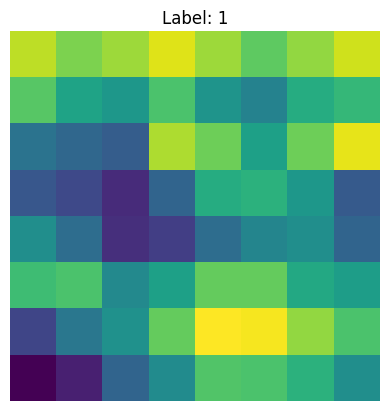

In [ ]:
# Load a small sample of BreastMNIST images (resized to 8×8)
# Fetches 10 training and 10 test images
x_train, y_train, x_test, y_test = load_breastmnist_data(num_train=10, num_test=10)

# Select a single example for visualization and encoding
features_sample = x_train[0]
print(features_sample)
label = y_train[0]

# Show the original image
import matplotlib.pyplot as plt
plt.imshow(features_sample.reshape(8, 8),cmap='gray')
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()


TypeError: Invalid shape (64,) for image data

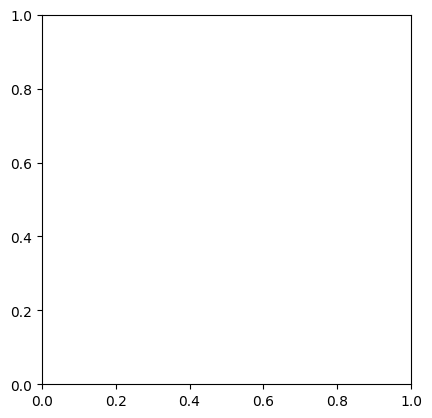

In [48]:
plt.imshow(x_train[0])

In [ ]:
from qiskit import ClassicalRegister
import matplotlib.pyplot as plt
from qiskit.visualization import circuit_drawer
import numpy as np

def visualize_qcnn_with_measurement(weights, last_layer_params, features, num_qubits=6, filename=None):
    """
    Builds the QCNN circuit, adds measurement to final decision qubit, and visualizes it.
    """
    qc, final_qubits = qcnn_circuit(
        weights, last_layer_params, features, num_qubits=num_qubits
    )

    # Add a classical register if none exists
    if not qc.cregs:
        creg = ClassicalRegister(1, name="c")
        qc.add_register(creg)
    else:
        creg = qc.cregs[0]

    # Add a measurement to the decision qubit (q0)
    qc.measure(final_qubits[0], creg[0])

    # Draw and optionally save
    circuit_drawer(qc, output="mpl", fold=-1, style={"fontsize": 12, "subfontsize": 10})
    plt.show()

    if filename:
        qc.draw(output="mpl", fold=-1, style={"fontsize": 12, "subfontsize": 10}).savefig(filename, dpi=300)
        print(f"✅ Circuit saved to {filename}")

    return qc

# Normalize for amplitude embedding
num_qubits = 6
features_padded = np.zeros(2**num_qubits)
features_padded[:64] = features_sample
features_padded /= np.linalg.norm(features_padded)

# Dummy weights (random for visualization)
weights_sample = np.random.rand(2, 18)   # Two layers, 18 parameters
last_layer_params = np.random.rand(15)   # Final SU(4) layer


visualize_qcnn_with_measurement(weights_sample, last_layer_params, features_sample, num_qubits, filename="qcnn_with_measurement.png")

✅ Circuit saved to qcnn_with_measurement.png


#### Having viewed a sample circuit for the fixed 6 qubit QCNN, from here on your task is to visualize a few samples of the encoded images (before and after encoding), vary the encoding methodologies and examine the circuit scaling.

Example of amplitude encoding

In [ ]:
#amplitude encoding
def amplitude_embedding_block(features: np.ndarray, num_qubits: int, pad_with=0.5, label="AmpEmbed"):
    """
    Create a subcircuit that prepares a state with amplitudes equal to the normalized feature vector.
    This mimics PennyLane's AmplitudeEmbedding.
    """

    # ✅ Ensure features is a NumPy array
    feat = np.asarray(features, dtype=np.float64)

    # ✅ Check if `feat` is still a scalar
    if feat.ndim == 0:
        raise ValueError(f"`features` should be an array, but got a scalar: {features}")


    # Ensure the feature vector has the correct length
    dim = 2 ** num_qubits
    
    if len(feat) < dim:
        feat = np.concatenate([feat, np.full(dim - len(feat), pad_with)])
    elif len(feat) > dim:
        raise ValueError(f"Feature length {len(feat)} exceeds 2^{num_qubits} = {dim}.")
    
    # Normalize
    norm = np.linalg.norm(feat) + 1e-10
    feat = feat / norm
    
    # Create a circuit and use the initialize method to prepare the state exactly
    encoding_circuit = QuantumCircuit(num_qubits, name=label)
    encoding_circuit.initialize(feat, list(range(num_qubits)))
    
    encoding_circuit.barrier()
    return encoding_circuit.to_instruction()

## QCNN Circuit Assembly

The `qcnn_circuit(...)` function below builds the full quantum circuit using:

1. A **data encoding block** (currently: Amplitude Embedding),
2. A stack of **convolution + pooling layers**,
3. A final **dense SU(4) layer**,
4. **No measurement** — this is added separately when needed.


### Your Task:

Replace the **amplitude embedding** block with a different encoding method of your choice:
-  **Angle Encoding:** apply `Ry(x[i])` or `Rz(x[i])` to each qubit,
-  **FRQI:** encode pixel intensity as rotation phase,
-  **QPIE:** map data using both position and intensity,
-  **Custom:** get creative, but make sure the feature vector matches the number of qubits!

You’ll do this by modifying the **encoding block** inside the function.


### Encoding Block to Replace

Inside the code below, you’ll see:
```python
# 2) Amplitude embedding
embed_gate = amplitude_embedding_block(features, num_qubits, pad_with=0.5, label="AmpEmbed")
qc.append(embed_gate, qargs=all_qubits)


Sample code for qcnn_circuit

In [ ]:
#qcnn_circuit

#Parametrizable circuit embedding


Amplitude_embedding=True
Angle_embedding_ry=False
Angle_embedding_rz=False
FQRI=False
QPIE=False
Custom = False

# Ensure exactly one embedding method is selected


def qcnn_circuit(
    weights,              # shape: (layers, total_params_per_layer)
    last_layer_unitary,   # 15 params for your final 2-qubit gate or a 4x4 matrix
    features,             # input features (for amplitude encoding)
    num_qubits_amp=6,Amplitude_embedding=True,
Angle_embedding_ry=False,
Angle_embedding_rz=False,
FQRI=False,
QPIE=False,
Custom = False
):
    if int(Amplitude_embedding) + int(Angle_embedding_ry) + int(FQRI) + int(QPIE) + int(Custom) + int(Angle_embedding_rz)  != 1:
        raise ValueError("🚨 ERROR: Exactly one embedding method must be selected.")

    """
    Build a Qiskit circuit that:
      1. Amplitude-embeds 'features' into 'num_qubits' qubits
      2. Applies convolution + pooling layers
      3. Applies a final dense 2-qubit SU(4) gate from PennyLane
      4. ❌ Does NOT include a measurement — handled separately

    Returns:
        qc (QuantumCircuit): The constructed quantum circuit.
        qubits_in_use (list): The final subset of qubits after pooling.
    """

    features = np.asarray(features, dtype=np.float64)

    if features.ndim == 0:
        raise ValueError(f"🚨 ERROR: `features` should be a 1D or 2D array, but got scalar {features}")

    # 1) Main circuit without classical register
    qc = None # To make qc global
    

    # 2a) Amplitude embedding
    if Amplitude_embedding:
        qc = QuantumCircuit(num_qubits_amp)
        all_qubits = list(range(num_qubits_amp))
        embed_gate = amplitude_embedding_block(features, num_qubits_amp, pad_with=0.5, label="AmpEmbed")
        qc.append(embed_gate, qargs=all_qubits)
    # 2b) Angle embedding Ry
    if Angle_embedding_ry:
        qc = QuantumCircuit(len(features))
        for i in range(len(features)):
           
            qc.ry(features[i], i)
    # 2c) Angle embedding Rz
    if Angle_embedding_rz:
        qc = QuantumCircuit(len(features))
        for i in range(len(features)):
            qc.rz(features[i], i)
    # 2d) FQRI embedding
    if FQRI:
       if FQRI:
        len_data = len(features)
        num_pos = int(np.ceil(np.log2(len_data)))
        # One qubit to store the color 
        num_qubits = num_pos + 1
        qc = QuantumCircuit(num_qubits)
        
        all_qubits = list(range(num_qubits))
        position_qubits = list(range(num_pos))
        color_qubit_index = num_pos 

        
        angles = features * (np.pi / 2)/255 # The feature are grayscale from 0 to 255
        for p in position_qubits:
            qc.h(p) # maximally entangled state i.e sum |i>
 
        for i, angle in enumerate(angles):
            
            control_state = format(i, f'0{num_pos}b') # find the binary string for the position pixel
            
            for j, bit in enumerate(control_state):
                if bit == '0': #make sure to flip the control qubit if the bit is 0
                    qc.x(j)
            
            multi_controll= RYGate(2*angle).control(len(position_qubits),label=None) #building of the multi controlled RY gate cf https://quantumcomputing.stackexchange.com/questions/27077/qiskit-custom-multi-controlled-gate
            qc.append(multi_controll, position_qubits + [color_qubit_index])

            for j, bit in enumerate(control_state):
                if bit == '0':
                    qc.x(j) # reset the control qubit
    
    if QPIE:
        l_2_norm= np.linalg.norm(features)
        normalized_features= features/l_2_norm
        len_data = len(normalized_features)
        qc = QuantumCircuit(len_data)
        qc.initialize(normalized_features, list(len_data))

    # 3) Convolution + Pooling
    layers = layers = len(weights)
    qubits_in_use = all_qubits.copy()

    for layer_idx in range(layers):
        if len(qubits_in_use) <= 2:
            break

        kernel_weights = weights[layer_idx]
        skip = layer_idx != 0
        qubits_in_use = conv_and_pooling(qc, kernel_weights, qubits_in_use, skip_first_layer=skip)

    # 4) Final Dense Layer
    if len(qubits_in_use) != 2:
        raise ValueError(f"After pooling, expected exactly 2 qubits, got {len(qubits_in_use)}.")

    if 0 not in qubits_in_use:
        raise ValueError(f"Final qubits do not include q0: {qubits_in_use}")

    # Ensure q0 is first
    if qubits_in_use[1] == 0:
        qubits_in_use = [qubits_in_use[1], qubits_in_use[0]]

    # ✅ Use PennyLane's ArbitraryUnitary → Qiskit's UnitaryGate wrapper
    dense_gate(qc, last_layer_unitary, qubits_in_use[0], qubits_in_use[1])

    return qc, qubits_in_use

In [ ]:
def encoder(
    weights,              # shape: (layers, total_params_per_layer)
    last_layer_unitary,   # 15 params for your final 2-qubit gate or a 4x4 matrix
    features,             # input features (for amplitude encoding)
    num_qubits_amp=6,Amplitude_embedding=True,
Angle_embedding_ry=False,
Angle_embedding_rz=False,
FQRI=False,
QPIE=False,
Custom = False
):
    if int(Amplitude_embedding) + int(Angle_embedding_ry) + int(FQRI) + int(QPIE) + int(Custom) + int(Angle_embedding_rz)  != 1:
        raise ValueError("🚨 ERROR: Exactly one embedding method must be selected.")

    """
    Build a Qiskit circuit that:
      1. Amplitude-embeds 'features' into 'num_qubits' qubits
      2. Applies convolution + pooling layers
      3. Applies a final dense 2-qubit SU(4) gate from PennyLane
      4. ❌ Does NOT include a measurement — handled separately

    Returns:
        qc (QuantumCircuit): The constructed quantum circuit.
        qubits_in_use (list): The final subset of qubits after pooling.
    """

    features = np.asarray(features, dtype=np.float64)

    if features.ndim == 0:
        raise ValueError(f"🚨 ERROR: `features` should be a 1D or 2D array, but got scalar {features}")

    # 1) Main circuit without classical register
    qc = None # To make qc global
    

    # 2a) Amplitude embedding
    if Amplitude_embedding:
        qc = QuantumCircuit(num_qubits_amp)
        all_qubits = list(range(num_qubits_amp))
        embed_gate = amplitude_embedding_block(features, num_qubits_amp, pad_with=0.5, label="AmpEmbed")
        qc.append(embed_gate, qargs=all_qubits)
    # 2b) Angle embedding Ry
    if Angle_embedding_ry:
        qc = QuantumCircuit(len(features))
        for i in range(len(features)):
           
            qc.ry(features[i], i)
    # 2c) Angle embedding Rz
    if Angle_embedding_rz:
        qc = QuantumCircuit(len(features))
        for i in range(len(features)):
            qc.rz(features[i], i)
    # 2d) FQRI embedding
    
    if FQRI:
        len_data = len(features)
        num_pos = int(np.ceil(np.log2(len_data)))
        # One qubit to store the color 
        num_qubits = num_pos + 1
        qc = QuantumCircuit(num_qubits)
        
        all_qubits = list(range(num_qubits))
        position_qubits = list(range(num_pos))
        color_qubit_index = num_pos 

        
        angles = features * (np.pi / 2)/255 # The feature are grayscale from 0 to 255
        for p in position_qubits:
            qc.h(p) # maximally entangled state i.e sum |i>
 
        for i, angle in enumerate(angles):
            
            control_state = format(i, f'0{num_pos}b') # find the binary string for the position pixel
            
            for j, bit in enumerate(control_state):
                if bit == '0': #make sure to flip the control qubit if the bit is 0
                    qc.x(j)
            
            multi_controll= qc.RYGate(2*angle).control(len(position_qubits),label=None) #building of the multi controlled RY gate cf https://quantumcomputing.stackexchange.com/questions/27077/qiskit-custom-multi-controlled-gate
            qc.append(multi_controll, position_qubits + [color_qubit_index])

            for j, bit in enumerate(control_state):
                if bit == '0':
                    qc.x(j) # reset the control qubit
    
    if QPIE:
        l_2_norm= np.linalg.norm(features)
        normalized_features= features/l_2_norm
        len_data = len(normalized_features)
        qc = QuantumCircuit(len_data)
        qc.initialize(normalized_features, list(len_data))
    return qc


In [ ]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, Pauli

def decode_ry_encoding(ry_circuit, simulation_method='statevector', shots=8192):
    
    num_qubits = ry_circuit.num_qubits
    reconstructed_angles = []

    for i in range(num_qubits):
        # To find the angle on qubit 'i', we must measure its <X> expectation value.
        
        # --- 1. PERFECT DECODING (STATEVECTOR) ---
        if simulation_method == 'statevector':
            state = Statevector(ry_circuit)
            # Create an operator that is Identity on all qubits except for X on qubit i
            op = Pauli('I' * (num_qubits - 1 - i) + 'X' + 'I' * i) #the expectation value of X is sin(theta)
            
            # For a state from RY(theta), <X> = sin(theta)
            expectation_value = state.expectation_value(op).real
            angle = np.arcsin(expectation_value)
            reconstructed_angles.append(angle)

        # --- 2. REALISTIC DECODING (SHOTS) ---
        elif simulation_method == 'shots':
            # To measure in the X-basis, apply an H gate before measuring
            qc = ry_circuit.copy()
            cr = ClassicalRegister(1, name="c")
            qc.add_register(cr)
            qc.h(i)
            qc.measure(i, cr)
            
            backend = AerSimulator()
            job = backend.run(qc, shots=shots)
            counts = job.result().get_counts()
            
            # The expectation value <X> is P(0) - P(1)
            p0 = counts.get('0', 0) / shots
            p1 = counts.get('1', 0) / shots
            expectation_value = p0 - p1
            
            # Solve for theta: arcsin(<X>) = theta
            angle = np.arcsin(expectation_value)
            reconstructed_angles.append(angle)
            
        else:
            raise ValueError("simulation_method must be 'statevector' or 'shots'")
    
    return np.array(reconstructed_angles)

In [ ]:
def encoder_ry(features):
    """A simple encoder for RY angle encoding."""
    qc = QuantumCircuit(len(features))
    for i, feature in enumerate(features):
        print(i)
        qc.ry(feature, i)
    return qc

# 1. Define original features (angles)
original_features = np.array([0.5, 1.2, np.pi/2, -0.3])

# 2. Encode the features using RY gates
ry_circuit = encoder_ry(original_features)
print("test")
ry_circuit.draw()

print("--- 🔬 Decoding Angle (RY) Encoding ---")

# 3. Decode using the perfect statevector method
rec_ry_sv = decode_ry_encoding(ry_circuit, 'statevector')

# 4. Decode using the realistic shots-based method
rec_ry_shots = decode_ry_encoding(ry_circuit, 'shots')

print("Original Angles:      ", np.round(original_features, 4))
print("Reconstructed (SV):   ", np.round(rec_ry_sv, 4))
print("Reconstructed (Shots):", np.round(rec_ry_shots, 4))

0
1
2
3
test
--- 🔬 Decoding Angle (RY) Encoding ---
Original Angles:       [ 0.5     1.2     1.5708 -0.3   ]
Reconstructed (SV):    [ 0.5     1.2     1.5708 -0.3   ]
Reconstructed (Shots): [ 0.5096  1.2161  1.5708 -0.3022]


In [ ]:
import numpy as np
import math
from qiskit import QuantumCircuit, ClassicalRegister
from qiskit.circuit.library import RYGate
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector
from qiskit.compiler import transpile

def encoder_frqi(features):
    """Creates a corrected FRQI circuit using the |position> ⊗ |color> convention."""
    num_pixels = len(features)
    num_pos_qubits = int(np.ceil(np.log2(num_pixels)))
    num_qubits = num_pos_qubits + 1
    qc = QuantumCircuit(num_qubits)
    
    # --- CONVENTION FIX ---
    # Qubit 0 is the color qubit (LSB)
    color_qubit_index = 0
    # Qubits 1, 2, ... are the position qubits
    position_qubits = list(range(1, num_qubits))
    # -----------------------

    angles = (features / 255.0) * (np.pi / 2)
    
    qc.h(position_qubits)
    
    for i, angle in enumerate(angles):
        if np.isclose(angle, 0): continue
        
        # The control state string for the position qubits
        control_state = format(i, f'0{num_pos_qubits}b')
        
        # Reverse the string to match Qiskit's LSB-first qubit indexing for position
        for j, bit in enumerate(reversed(control_state)):
            # j=0 corresponds to the LSB of position, which is qubit 1
            # j=1 corresponds to the next bit, which is qubit 2, etc.
            if bit == '0': qc.x(position_qubits[j])
        
        mcr_gate = RYGate(2 * angle).control(num_pos_qubits)
        # The controls are the position qubits, the target is the color qubit
        qc.append(mcr_gate, position_qubits + [color_qubit_index])

        # Un-compute the X-gates
        for j, bit in enumerate(reversed(control_state)):
            if bit == '0': qc.x(position_qubits[j])
            
    return qc

In [ ]:
def decode_frqi(frqi_circuit, simulation_method='statevector', shots=8192):
    """Decodes an FRQI state using the |position> ⊗ |color> convention."""
    num_qubits = frqi_circuit.num_qubits
    num_pos_qubits = num_qubits - 1
    num_pixels = 2**num_pos_qubits
    
    if simulation_method == 'statevector':
        state = Statevector(frqi_circuit)
        data = state.data
        reconstructed_pixels = []
        for i in range(num_pixels):
            # --- CONVENTION FIX ---
            # Index for |pos, color=0> is the integer for the state where the color bit (q0) is 0.
            # This is simply the position value 'i' shifted left by 1 bit.
            idx0 = i << 1 
            # Index for |pos, color=1> is the same, but with the color bit (q0) as 1.
            idx1 = (i << 1) + 1
            # -----------------------

            amp0 = data[idx0]
            amp1 = data[idx1]
            
            angle = np.arctan2(np.real(amp1), np.real(amp0))
            pixel_value = (angle / (np.pi / 2)) * 255
            reconstructed_pixels.append(pixel_value)
        return np.array(reconstructed_pixels)

    elif simulation_method == 'shots':
        # This part of the code from the previous fix was already assuming the
        # correct little-endian format from Qiskit's counts, so it requires minimal changes.
        # The counts key 'p...c' corresponds to |...position...color>.
        qc = frqi_circuit.copy()
        cr = ClassicalRegister(num_qubits)
        qc.add_register(cr)
        qc.measure(range(num_qubits), range(num_qubits))
        
        backend = AerSimulator()
        transpiled_qc = transpile(qc, backend)
        job = backend.run(transpiled_qc, shots=shots)
        counts = job.result().get_counts()

        reconstructed_pixels = []
        for i in range(num_pixels):
            # Qiskit's count key is MSB...LSB, so '...pos...color'
            pos_state = format(i, f'0{num_pos_qubits}b')
            
            count0 = counts.get(pos_state + '0', 0)
            count1 = counts.get(pos_state + '1', 0)
            total_pos_counts = count0 + count1
            
            if total_pos_counts == 0:
                angle = 0
            else:
                prob_color_1 = count1 / total_pos_counts
                angle = np.arcsin(np.sqrt(prob_color_1))
            
            pixel_value = (angle / (np.pi / 2)) * 255
            reconstructed_pixels.append(pixel_value)
        return np.array(reconstructed_pixels)

In [ ]:
# 1. Define original 2x2 image (4 pixels)
image_shape = (4 ,4)
original_features = np.array([0, 85, 170, 255,192,12,2,3,4,5,6,7,8,14,15,16])

# 2. Encode the features using the CORRECTED FRQI method
frqi_circuit = encoder_frqi(original_features)

print("--- 🖼️ Decoding FRQI (Final Correction) ---")

# 3. Decode using the perfect statevector method
rec_frqi_sv = decode_frqi(frqi_circuit, 'shots')

print("Original Image:\n", original_features.reshape(image_shape))
print("\nReconstructed (Statevector):\n", np.round(rec_frqi_sv).reshape(image_shape))

--- 🖼️ Decoding FRQI (Final Correction) ---
Original Image:
 [[  0  85 170 255]
 [192  12   2   3]
 [  4   5   6   7]
 [  8  14  15  16]]

Reconstructed (Statevector):
 [[  0.  89. 166. 255.]
 [189.  10.   0.   0.]
 [  0.   0.  10.   7.]
 [  0.  14.  16.  16.]]


In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import RYGate
ccry = RYGate(np.pi/8).control(2,label=None)
circ = QuantumCircuit(4)
circ.append(ccry,[0,1,3])
circ.draw()

q_0: ──────────────■─────────────────■──
                   │                 │  
q_1: ──────────────■─────────────────■──
     ┌──────────┐┌─┴─┐┌───────────┐┌─┴─┐
q_2: ┤ Ry(π/16) ├┤ X ├┤ Ry(-π/16) ├┤ X ├
     └──────────┘└───┘└───────────┘└───┘
q_3: ───────────────────────────────────

Loading BreastMNIST dataset...
Encoding the 32x32 image...
FRQI circuit created with 11 qubits.

Decoding with statevector simulator (perfect reconstruction)...
Decoding with shots simulator (realistic reconstruction)...


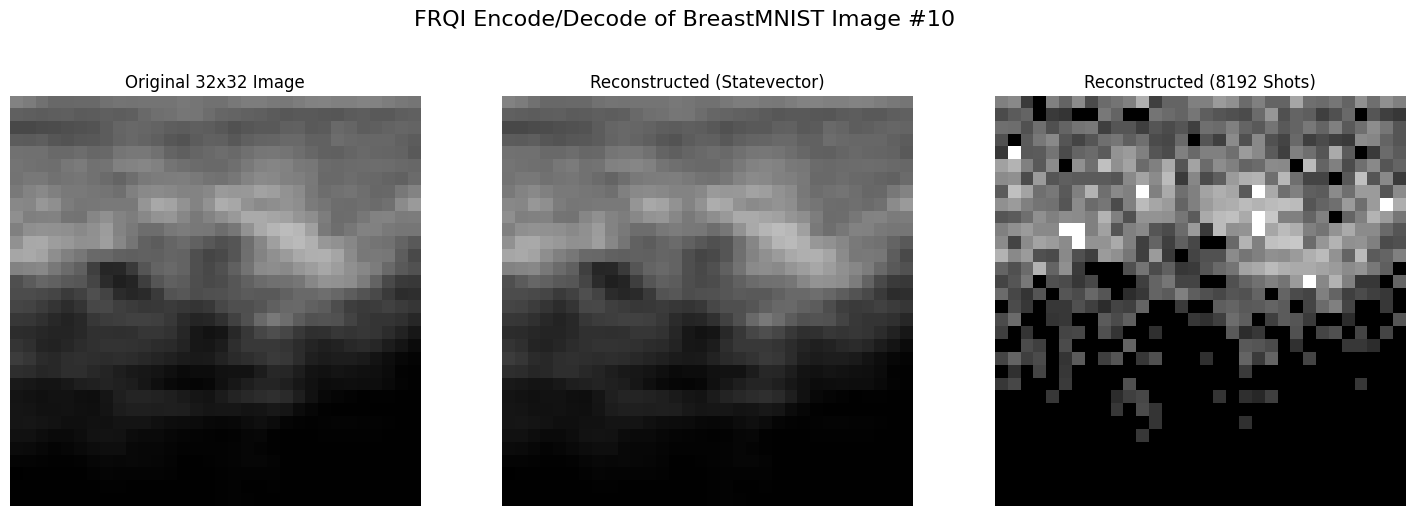

In [51]:
import numpy as np
import math
import matplotlib.pyplot as plt
from PIL import Image

from qiskit import QuantumCircuit, ClassicalRegister
from qiskit.circuit.library import RYGate
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector
from qiskit.compiler import transpile

# MedMNIST for the dataset
import medmnist
from medmnist import BreastMNIST

# --- Step 1: Paste the corrected Encoder and Decoder functions ---

def encoder_frqi(features):
    """Creates a corrected FRQI circuit using the |position> ⊗ |color> convention."""
    num_pixels = len(features)
    num_pos_qubits = int(np.ceil(np.log2(num_pixels)))
    num_qubits = num_pos_qubits + 1
    qc = QuantumCircuit(num_qubits)
    
    color_qubit_index = 0
    position_qubits = list(range(1, num_qubits))

    angles = (features / 255.0) * (np.pi / 2)
    qc.h(position_qubits)
    
    for i, angle in enumerate(angles):
        if np.isclose(angle, 0): continue
        control_state = format(i, f'0{num_pos_qubits}b')
        for j, bit in enumerate(reversed(control_state)):
            if bit == '0': qc.x(position_qubits[j])
        
        mcr_gate = RYGate(2 * angle).control(num_pos_qubits)
        qc.append(mcr_gate, position_qubits + [color_qubit_index])

        for j, bit in enumerate(reversed(control_state)):
            if bit == '0': qc.x(position_qubits[j])
            
    return qc

def decode_frqi(frqi_circuit, simulation_method='statevector', shots=1024):
    """Decodes an FRQI state, with transpilation for shots-based simulation."""
    num_qubits = frqi_circuit.num_qubits
    num_pos_qubits = num_qubits - 1
    num_pixels = 2**num_pos_qubits
    
    if simulation_method == 'statevector':
        state = Statevector(frqi_circuit)
        data = state.data
        reconstructed_pixels = []
        for i in range(num_pixels):
            idx0 = i << 1 
            idx1 = (i << 1) + 1
            amp0, amp1 = data[idx0], data[idx1]
            angle = np.arctan2(np.real(amp1), np.real(amp0))
            pixel_value = (angle / (np.pi / 2)) * 255
            reconstructed_pixels.append(pixel_value)
        return np.array(reconstructed_pixels)

    elif simulation_method == 'shots':
        backend = AerSimulator()
        qc = frqi_circuit.copy()
        
        cr = ClassicalRegister(num_qubits)
        qc.add_register(cr)
        qc.measure(range(num_qubits), range(num_qubits))
        
        transpiled_qc = transpile(qc, backend)
        job = backend.run(transpiled_qc, shots=shots)
        counts = job.result().get_counts()

        reconstructed_pixels = []
        for i in range(num_pixels):
            pos_state = format(i, f'0{num_pos_qubits}b')
            count0 = counts.get(pos_state + '0', 0)
            count1 = counts.get(pos_state + '1', 0)
            total_pos_counts = count0 + count1
            
            if total_pos_counts == 0:
                angle = 0
            else:
                prob_color_1 = count1 / total_pos_counts
                angle = np.arcsin(np.sqrt(prob_color_1))
            
            pixel_value = (angle / (np.pi / 2)) * 255
            reconstructed_pixels.append(pixel_value)
        return np.array(reconstructed_pixels)

# --- Step 2: Load and Pre-process a BreastMNIST image ---

print("Loading BreastMNIST dataset...")
train_dataset = BreastMNIST(split="train", download=True)

# Select an image (e.g., the 10th image in the dataset)
IMAGE_INDEX = 10
pil_image, label = train_dataset[IMAGE_INDEX]

# Pre-process the image for FRQI
TARGET_SIZE = (32, 32) # 8x8 = 64 pixels = 2^6 pixels
image_resized = pil_image.resize(TARGET_SIZE, Image.Resampling.LANCZOS)
image_np = np.array(image_resized)
features = image_np.flatten() # Flatten the 2D image to a 1D vector

# --- Step 3: Encode and Decode the Image ---

print(f"Encoding the {TARGET_SIZE[0]}x{TARGET_SIZE[1]} image...")
frqi_circuit = encoder_frqi(features)
# For an 8x8=64 pixel image, we need log2(64)=6 position qubits + 1 color qubit
print(f"FRQI circuit created with {frqi_circuit.num_qubits} qubits.")

print("\nDecoding with statevector simulator (perfect reconstruction)...")
reconstructed_sv = decode_frqi(frqi_circuit, 'statevector')
image_sv = reconstructed_sv.reshape(TARGET_SIZE)

print("Decoding with shots simulator (realistic reconstruction)...")
reconstructed_shots = decode_frqi(frqi_circuit, 'shots', shots=8192)
image_shots = reconstructed_shots.reshape(TARGET_SIZE)

# --- Step 4: Visualize the Results ---

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle(f'FRQI Encode/Decode of BreastMNIST Image #{IMAGE_INDEX}', fontsize=16)

axes[0].imshow(image_np, cmap='gray', vmin=0, vmax=255)
axes[0].set_title(f"Original {TARGET_SIZE[0]}x{TARGET_SIZE[1]} Image")
axes[0].axis('off')

axes[1].imshow(image_sv, cmap='gray', vmin=0, vmax=255)
axes[1].set_title("Reconstructed (Statevector)")
axes[1].axis('off')

axes[2].imshow(image_shots, cmap='gray', vmin=0, vmax=255)
axes[2].set_title("Reconstructed (8192 Shots)")
axes[2].axis('off')

plt.show()

### Encode, Decode & Evaluate Your Image

Once you've selected and implemented your image encoding scheme (Amplitude, QPIE, Angle, etc.), it's time to test how well it preserves the information in the image.

#### Example Output


Here’s a visualization of a 64×64 BreastMNIST sample before and after reconstruction using QPIE:

![Sample breastMNIST decoded](breastMNIST_encode_decode.png)

Left: Original image (Benign case)

Right: Reconstructed image after encoding + decoding with QPIE

You should generate similar visuals for each encoding method you experiment with.

#### What You Need to Do

Choose a BreastMNIST sample and resize it to 8×8, 16×16, 32×32, and 64×64 resolutions.

Implement an encoding + decoding pipeline:

Encode image → quantum state

Measure or decode → reconstructed image

Compare original vs reconstructed visually and quantitatively.

#### Metrics to Report

For each encoding method and image resolution:

Compute MSE (Mean Squared Error)

Compute SSIM (Structural Similarity Index)

Vary the number of shots (e.g. 1024, 4096, … up to 1M) to simulate measurement noise

Then, plot something like this: ![Encoding Fidelity](encoding.png)

This shows how reconstruction fidelity changes with number of shots.

Loading BreastMNIST dataset...

--- Processing Resolution: 8x8 ---
Encoding 8x8 image on 7 qubits...
Encoding took 0.07 seconds.
Decoding with statevector...
Decoding with 1024 shots...
  -> MSE: 644.30, SSIM: 0.8721 (took 0.60s)
Decoding with 4096 shots...
  -> MSE: 119.71, SSIM: 0.9755 (took 0.62s)
Decoding with 8192 shots...
  -> MSE: 54.30, SSIM: 0.9891 (took 0.58s)
Decoding with 16384 shots...
  -> MSE: 24.85, SSIM: 0.9954 (took 0.57s)
Decoding with 32768 shots...
  -> MSE: 13.09, SSIM: 0.9972 (took 0.62s)
Decoding with 65536 shots...
  -> MSE: 7.42, SSIM: 0.9987 (took 0.59s)

--- Processing Resolution: 16x16 ---
Encoding 16x16 image on 9 qubits...
Encoding took 0.24 seconds.
Decoding with statevector...
Decoding with 1024 shots...
  -> MSE: 4175.29, SSIM: 0.4153 (took 6.05s)
Decoding with 4096 shots...
  -> MSE: 561.14, SSIM: 0.7645 (took 6.10s)
Decoding with 8192 shots...
  -> MSE: 245.45, SSIM: 0.8929 (took 5.99s)
Decoding with 16384 shots...
  -> MSE: 126.18, SSIM: 0.9387 (too

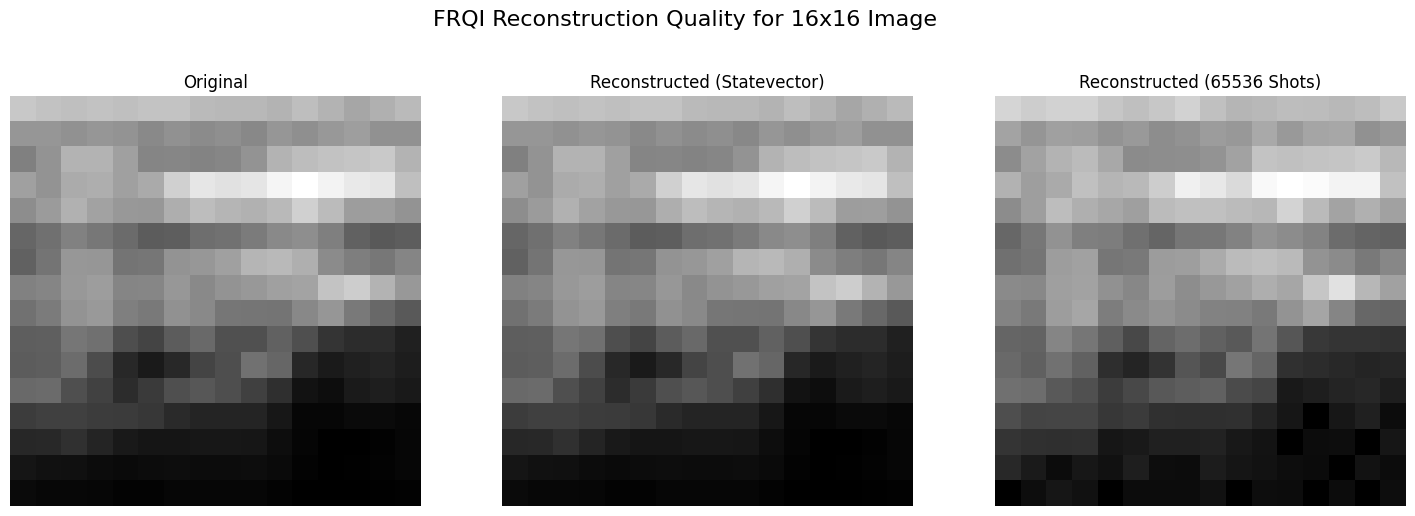

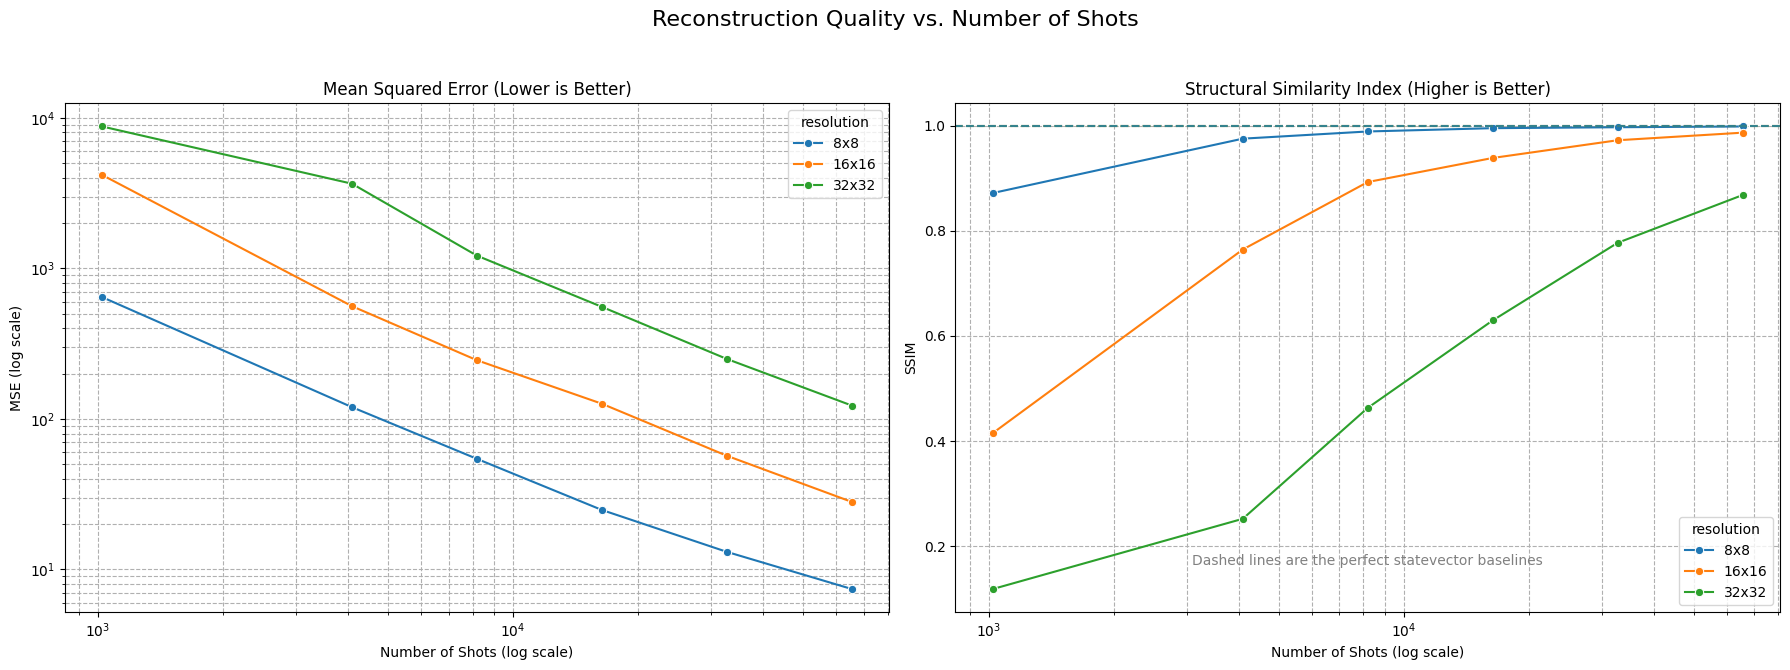

In [52]:
import numpy as np
import math
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import seaborn as sns
import time

# Qiskit Imports
from qiskit import QuantumCircuit, ClassicalRegister
from qiskit.circuit.library import RYGate
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector
from qiskit.compiler import transpile

# MedMNIST for the dataset
import medmnist
from medmnist import BreastMNIST

# Scikit-image for metrics
from skimage.metrics import mean_squared_error, structural_similarity

# ===================================================================
# Part 1: Helper Functions (Encoder, Decoder, Metrics)
# ===================================================================

def encoder_frqi(features):
    """Encodes a 1D array of pixel values into an FRQI quantum state."""
    num_pixels = len(features)
    num_pos_qubits = int(np.ceil(np.log2(num_pixels)))
    num_qubits = num_pos_qubits + 1
    qc = QuantumCircuit(num_qubits)
    
    color_qubit_index = 0
    position_qubits = list(range(1, num_qubits))

    angles = (features / 255.0) * (np.pi / 2)
    qc.h(position_qubits)
    
    for i, angle in enumerate(angles):
        if np.isclose(angle, 0): continue
        control_state = format(i, f'0{num_pos_qubits}b')
        for j, bit in enumerate(reversed(control_state)):
            if bit == '0': qc.x(position_qubits[j])
        
        mcr_gate = RYGate(2 * angle).control(num_pos_qubits)
        qc.append(mcr_gate, position_qubits + [color_qubit_index])

        for j, bit in enumerate(reversed(control_state)):
            if bit == '0': qc.x(position_qubits[j])
            
    return qc

def decode_frqi(frqi_circuit, simulation_method='statevector', shots=8192):
    """Decodes an FRQI quantum state back to a classical image array."""
    num_qubits = frqi_circuit.num_qubits
    num_pos_qubits = num_qubits - 1
    num_pixels = 2**num_pos_qubits
    
    if simulation_method == 'statevector':
        state = Statevector(frqi_circuit)
        data = state.data
        reconstructed_pixels = np.zeros(num_pixels)
        for i in range(num_pixels):
            idx0, idx1 = (i << 1), (i << 1) + 1
            amp0, amp1 = data[idx0], data[idx1]
            angle = np.arctan2(np.real(amp1), np.real(amp0))
            reconstructed_pixels[i] = (angle / (np.pi / 2)) * 255
        return reconstructed_pixels

    elif simulation_method == 'shots':
        backend = AerSimulator()
        qc = frqi_circuit.copy()
        
        cr = ClassicalRegister(num_qubits)
        qc.add_register(cr)
        qc.measure(range(num_qubits), range(num_qubits))
        
        transpiled_qc = transpile(qc, backend)
        job = backend.run(transpiled_qc, shots=shots)
        counts = job.result().get_counts()

        reconstructed_pixels = np.zeros(num_pixels)
        for i in range(num_pixels):
            pos_state = format(i, f'0{num_pos_qubits}b')
            count0 = counts.get(pos_state + '0', 0)
            count1 = counts.get(pos_state + '1', 0)
            total = count0 + count1
            angle = 0 if total == 0 else np.arcsin(np.sqrt(count1 / total))
            reconstructed_pixels[i] = (angle / (np.pi / 2)) * 255
        return reconstructed_pixels

def calculate_metrics(original_img, reconstructed_img):
    """Calculates MSE and SSIM between two images."""
    mse = mean_squared_error(original_img, reconstructed_img)
    # data_range is crucial for SSIM
    ssim = structural_similarity(original_img, reconstructed_img, data_range=255)
    return mse, ssim

# ===================================================================
# Part 2: The Main Experiment
# ===================================================================

# --- Configuration ---
RESOLUTIONS = [8, 16, 32] # 64x64 is very slow, starting with 8, 16, 32
SHOT_COUNTS = [1024, 4096, 8192, 16384, 32768, 65536]
IMAGE_INDEX = 42 # Choose a sample image from the dataset

# --- Load Data ---
print("Loading BreastMNIST dataset...")
train_dataset = BreastMNIST(split="train", download=True)
pil_image, label = train_dataset[IMAGE_INDEX]

# --- Run Experiment Loop ---
results = []
reconstructed_images = {} # To store some images for visual comparison

for res in RESOLUTIONS:
    print(f"\n--- Processing Resolution: {res}x{res} ---")
    target_size = (res, res)
    
    # 1. Pre-process Image
    image_resized = pil_image.resize(target_size, Image.Resampling.LANCZOS)
    original_np = np.array(image_resized)
    features = original_np.flatten()
    reconstructed_images[res] = {'original': original_np}
    
    # 2. Encode Image (once per resolution)
    start_time = time.time()
    print(f"Encoding {res}x{res} image on {int(np.log2(res**2))+1} qubits...")
    frqi_circuit = encoder_frqi(features)
    print(f"Encoding took {time.time() - start_time:.2f} seconds.")
    
    # 3. Decode with Statevector (perfect baseline)
    print("Decoding with statevector...")
    rec_sv = decode_frqi(frqi_circuit, 'statevector')
    reconstructed_images[res]['statevector'] = rec_sv.reshape(target_size)
    baseline_mse, baseline_ssim = calculate_metrics(original_np, rec_sv.reshape(target_size))
    
    # 4. Decode with varying shots
    for shots in SHOT_COUNTS:
        start_time = time.time()
        print(f"Decoding with {shots} shots...")
        rec_shots = decode_frqi(frqi_circuit, 'shots', shots=shots)
        
        mse, ssim = calculate_metrics(original_np, rec_shots.reshape(target_size))
        
        results.append({
            'resolution': f"{res}x{res}",
            'shots': shots,
            'mse': mse,
            'ssim': ssim,
            'baseline_ssim': baseline_ssim # Store baseline for plotting
        })
        print(f"  -> MSE: {mse:.2f}, SSIM: {ssim:.4f} (took {time.time() - start_time:.2f}s)")

        if shots == SHOT_COUNTS[-1]: # Save the highest shot count image
            reconstructed_images[res]['shots'] = rec_shots.reshape(target_size)

# Convert results to a DataFrame for easy plotting
results_df = pd.DataFrame(results)

# ===================================================================
# Part 3: Visualization
# ===================================================================

# --- 1. Visual Comparison of Reconstructed Images ---
res_to_show = 16 # Choose a resolution to display
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle(f'FRQI Reconstruction Quality for {res_to_show}x{res_to_show} Image', fontsize=16)
axes[0].imshow(reconstructed_images[res_to_show]['original'], cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')
axes[1].imshow(reconstructed_images[res_to_show]['statevector'], cmap='gray')
axes[1].set_title('Reconstructed (Statevector)')
axes[1].axis('off')
axes[2].imshow(reconstructed_images[res_to_show]['shots'], cmap='gray')
axes[2].set_title(f'Reconstructed ({SHOT_COUNTS[-1]} Shots)')
axes[2].axis('off')
plt.show()


# --- 2. Quantitative Metric Plots ---
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Reconstruction Quality vs. Number of Shots', fontsize=16)

# MSE Plot
sns.lineplot(data=results_df, x='shots', y='mse', hue='resolution', marker='o', ax=axes[0])
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_title('Mean Squared Error (Lower is Better)')
axes[0].set_xlabel('Number of Shots (log scale)')
axes[0].set_ylabel('MSE (log scale)')
axes[0].grid(True, which="both", ls="--")

# SSIM Plot
sns.lineplot(data=results_df, x='shots', y='ssim', hue='resolution', marker='o', ax=axes[1])
# Add horizontal lines for the perfect statevector baseline SSIM
for res_str, group in results_df.groupby('resolution'):
    axes[1].axhline(y=group['baseline_ssim'].iloc[0], color=sns.color_palette()[list(results_df.resolution.unique()).index(res_str)], linestyle='--', alpha=0.7)
axes[1].set_xscale('log')
axes[1].set_title('Structural Similarity Index (Higher is Better)')
axes[1].set_xlabel('Number of Shots (log scale)')
axes[1].set_ylabel('SSIM')
axes[1].grid(True, which="both", ls="--")
axes[1].text(0.5, 0.1, 'Dashed lines are the perfect statevector baselines', 
             ha='center', va='center', transform=axes[1].transAxes, 
             fontsize=10, color='gray')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [55]:
import numpy as np
from qiskit import QuantumCircuit, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, Pauli

def decode_ry_encoding(ry_circuit, 
                       simulation_method='statevector', 
                       shots=8192, 
                       backend_method='statevector'):
    """
    Decodes an RY-encoded circuit, with an option for tensor network simulation.
    """
    num_qubits = ry_circuit.num_qubits
    reconstructed_angles = []

    # For large qubit counts, statevector simulation is not possible.
    if num_qubits > 20 and simulation_method == 'statevector':
        raise ValueError(f"Statevector simulation for {num_qubits} qubits is not feasible.")

    for i in range(num_qubits):
        # Statevector method remains the same, as it doesn't use the Aer backend directly
        if simulation_method == 'statevector':
            state = Statevector(ry_circuit)
            op = Pauli('I' * (num_qubits - 1 - i) + 'X' + 'I' * i)
            expectation_value = state.expectation_value(op).real
            angle = np.arcsin(expectation_value)
            reconstructed_angles.append(angle)

        elif simulation_method == 'shots':
            qc = ry_circuit.copy()
            cr = ClassicalRegister(1, name="c")
            qc.add_register(cr)
            qc.h(i)
            qc.measure(i, cr)
            
            # --- THE CHANGE IS HERE ---
            # Select the simulation method for the backend
            backend = AerSimulator(method=backend_method)
            # -----------------------
            
            job = backend.run(qc, shots=shots)
            counts = job.result().get_counts()
            
            p0 = counts.get('0', 0) / shots
            p1 = counts.get('1', 0) / shots
            expectation_value = p0 - p1
            angle = np.arcsin(expectation_value)
            reconstructed_angles.append(angle)
    
    return np.array(reconstructed_angles)

def encoder_ry(features):
    """Encodes a 1D array of pixel values using RY angle encoding."""
    angles = (features / 255.0) * np.pi
    qc = QuantumCircuit(len(features))
    for i, angle in enumerate(angles):
        qc.ry(angle, i)
    return qc

Loading BreastMNIST dataset...
Encoding 16x16 image on 256 qubits...
Encoding complete.

Decoding with Tensor Network Simulator (this may take a few minutes)...
Decoding complete.


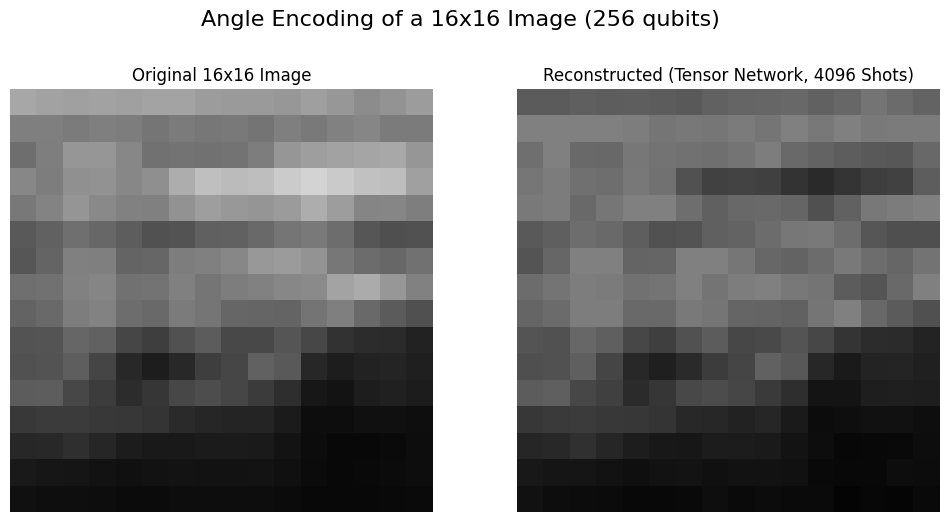

In [57]:
from PIL import Image
import medmnist
from medmnist import BreastMNIST
import matplotlib.pyplot as plt

# --- 1. Load and Pre-process a 16x16 Image ---
print("Loading BreastMNIST dataset...")
train_dataset = BreastMNIST(split="train", download=True)
pil_image, label = train_dataset[42]

TARGET_SIZE = (16, 16)
image_resized = pil_image.resize(TARGET_SIZE, Image.Resampling.LANCZOS)
original_np = np.array(image_resized)
features = original_np.flatten() # 256 features

# --- 2. Encode the 256-pixel image ---
print(f"Encoding {TARGET_SIZE[0]}x{TARGET_SIZE[1]} image on {len(features)} qubits...")
ry_circuit = encoder_ry(features)
print("Encoding complete.")

# --- 3. Decode using Tensor Network Simulator ---
# Note: We can only use the 'shots' method. 'statevector' would require too much memory.
print("\nDecoding with Tensor Network Simulator (this may take a few minutes)...")
rec_angles_tn = decode_ry_encoding(ry_circuit, 
                                   simulation_method='shots', 
                                   shots=4096, 
                                   backend_method='matrix_product_state')

# Convert angles back to pixel values
rec_pixels_tn = (rec_angles_tn / np.pi) * 255.0
image_tn = rec_pixels_tn.reshape(TARGET_SIZE)
print("Decoding complete.")

# --- 4. Visualize the Results ---
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle(f'Angle Encoding of a 16x16 Image ({len(features)} qubits)', fontsize=16)

axes[0].imshow(original_np, cmap='gray', vmin=0, vmax=255)
axes[0].set_title(f"Original {TARGET_SIZE[0]}x{TARGET_SIZE[1]} Image")
axes[0].axis('off')

axes[1].imshow(image_tn, cmap='gray', vmin=0, vmax=255)
axes[1].set_title("Reconstructed (Tensor Network, 4096 Shots)")
axes[1].axis('off')

plt.show()

Loading BreastMNIST dataset...

--- Processing Resolution: 8x8 (64 qubits) ---
Encoding 8x8 image...
Decoding with 1024 shots...
  -> MSE: 604.45, SSIM: 0.8427 (took 0.30s)
Decoding with 4096 shots...
  -> MSE: 615.27, SSIM: 0.8398 (took 0.42s)
Decoding with 8192 shots...
  -> MSE: 606.87, SSIM: 0.8416 (took 0.60s)
Decoding with 16384 shots...
  -> MSE: 607.11, SSIM: 0.8420 (took 1.74s)

--- Processing Resolution: 16x16 (256 qubits) ---
⚠️ This resolution will be very slow.
Encoding 16x16 image...
Decoding with 1024 shots...
  -> MSE: 1183.12, SSIM: 0.4819 (took 3.07s)
Decoding with 4096 shots...
  -> MSE: 1191.54, SSIM: 0.4850 (took 3.09s)
Decoding with 8192 shots...
  -> MSE: 1180.55, SSIM: 0.4884 (took 4.14s)
Decoding with 16384 shots...
  -> MSE: 1185.35, SSIM: 0.4863 (took 5.56s)

--- Processing Resolution: 32x32 (1024 qubits) ---
⚠️ This resolution will be very slow.
Encoding 32x32 image...
Decoding with 1024 shots...
  -> MSE: 1345.21, SSIM: 0.4146 (took 36.73s)
Decoding with 40

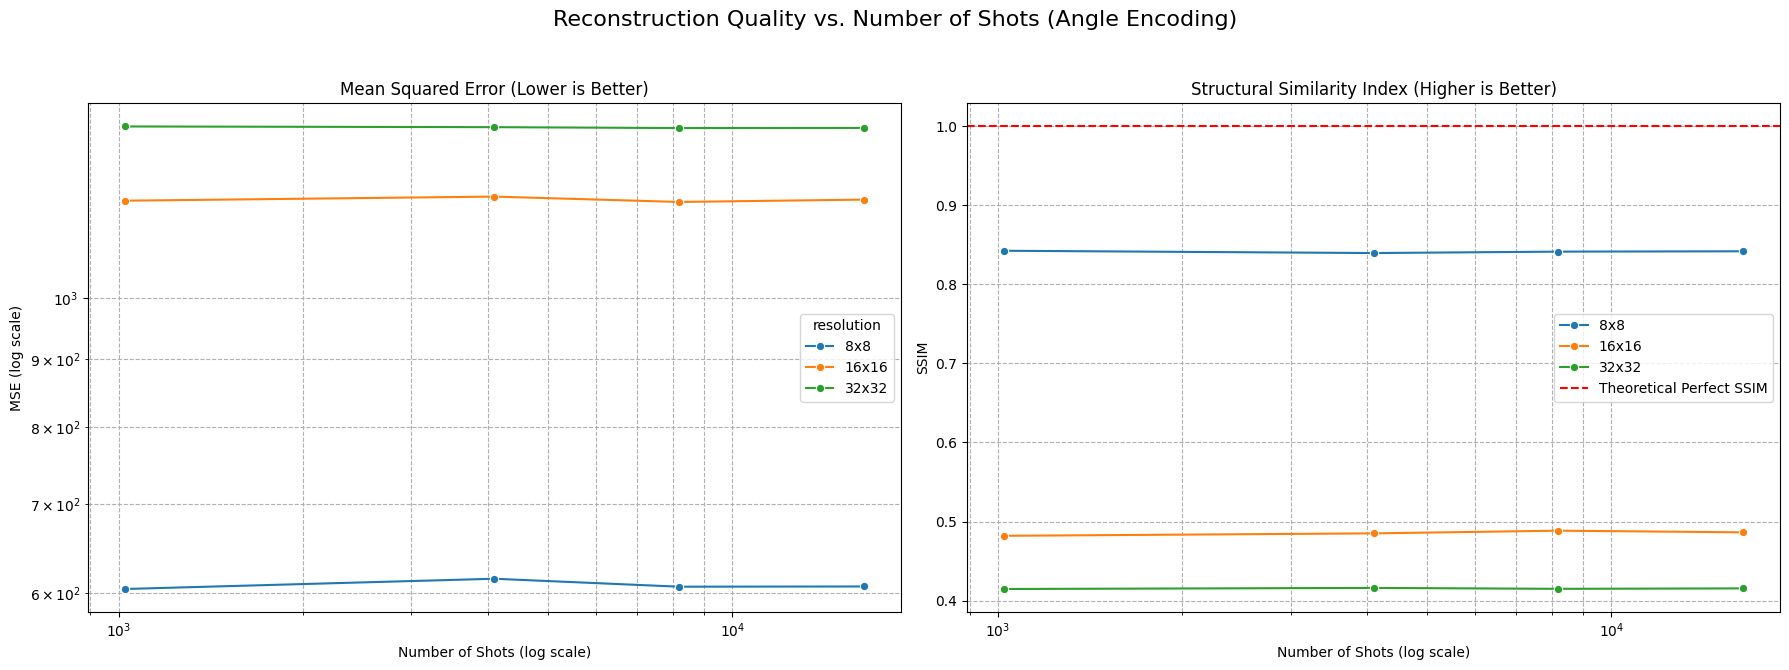

In [60]:
import numpy as np
import math
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import seaborn as sns
import time

# Qiskit Imports
from qiskit import QuantumCircuit, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Pauli

# MedMNIST for the dataset
import medmnist
from medmnist import BreastMNIST

# Scikit-image for metrics
from skimage.metrics import mean_squared_error, structural_similarity

# ===================================================================
# Part 1: Helper Functions
# ===================================================================

def encoder_ry(features):
    """Encodes a 1D array of pixel values using RY angle encoding."""
    angles = (features / 255.0) * np.pi
    qc = QuantumCircuit(len(features))
    for i, angle in enumerate(angles):
        qc.ry(angle, i)
    return qc

def decode_ry_encoding_shots(ry_circuit, shots=8192):
    """Decodes an RY-encoded circuit using only shots-based simulation."""
    num_qubits = ry_circuit.num_qubits
    reconstructed_angles = []
    
    # Use the 'matrix_product_state' simulator for multi-qubit circuits
    backend = AerSimulator(method='matrix_product_state')

    # This loop is why this method is slow: N simulations for N pixels
    for i in range(num_qubits):
        qc = ry_circuit.copy()
        cr = ClassicalRegister(1, name="c")
        qc.add_register(cr)
        qc.h(i)
        qc.measure(i, cr)
        
        job = backend.run(qc, shots=shots)
        counts = job.result().get_counts()
        
        p0 = counts.get('0', 0) / shots
        p1 = counts.get('1', 0) / shots
        expectation_value = p0 - p1
        angle = np.arcsin(expectation_value)
        reconstructed_angles.append(angle)
    
    return np.array(reconstructed_angles)

def calculate_metrics(original_img, reconstructed_img):
    """Calculates MSE and SSIM between two images."""
    mse = mean_squared_error(original_img, reconstructed_img)
    ssim = structural_similarity(original_img, reconstructed_img, data_range=255)
    return mse, ssim

# ===================================================================
# Part 2: The Main Experiment
# ===================================================================

# --- Configuration ---
# WARNING: 16x16 is very slow (hours), 32x32 is extremely slow (days).
# Adjust this list based on the time you have.
RESOLUTIONS = [8, 16, 32] 
SHOT_COUNTS = [1024, 4096, 8192, 16384]
IMAGE_INDEX = 42

# --- Load Data ---
print("Loading BreastMNIST dataset...")
train_dataset = BreastMNIST(split="train", download=True)
pil_image, label = train_dataset[IMAGE_INDEX]

# --- Run Experiment Loop ---
results = []
start_total_time = time.time()

for res in RESOLUTIONS:
    num_qubits = res * res
    print(f"\n--- Processing Resolution: {res}x{res} ({num_qubits} qubits) ---")
    if res > 8:
        print("⚠️ This resolution will be very slow.")
        
    target_size = (res, res)
    
    # 1. Pre-process Image
    image_resized = pil_image.resize(target_size, Image.Resampling.LANCZOS)
    original_np = np.array(image_resized)
    features = original_np.flatten()
    
    # 2. Encode Image
    print(f"Encoding {res}x{res} image...")
    ry_circuit = encoder_ry(features)
    
    # 3. Decode with varying shots
    for shots in SHOT_COUNTS:
        start_time = time.time()
        print(f"Decoding with {shots} shots...")
        
        rec_angles_shots = decode_ry_encoding_shots(ry_circuit, shots=shots)
        rec_pixels_shots = (rec_angles_shots / np.pi) * 255.0
        
        mse, ssim = calculate_metrics(original_np, rec_pixels_shots.reshape(target_size))
        
        results.append({
            'resolution': f"{res}x{res}",
            'shots': shots,
            'mse': mse,
            'ssim': ssim,
        })
        print(f"  -> MSE: {mse:.2f}, SSIM: {ssim:.4f} (took {time.time() - start_time:.2f}s)")

# Convert results to a DataFrame for easy plotting
results_df = pd.DataFrame(results)
print(f"\nTotal experiment time: {(time.time() - start_total_time)/60:.2f} minutes.")

# ===================================================================
# Part 3: Visualization
# ===================================================================

print("\nGenerating plots...")
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Reconstruction Quality vs. Number of Shots (Angle Encoding)', fontsize=16)

# MSE Plot
sns.lineplot(data=results_df, x='shots', y='mse', hue='resolution', marker='o', ax=axes[0])
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_title('Mean Squared Error (Lower is Better)')
axes[0].set_xlabel('Number of Shots (log scale)')
axes[0].set_ylabel('MSE (log scale)')
axes[0].grid(True, which="both", ls="--")

# SSIM Plot
sns.lineplot(data=results_df, x='shots', y='ssim', hue='resolution', marker='o', ax=axes[1])
axes[1].axhline(y=1.0, color='r', linestyle='--', label='Theoretical Perfect SSIM')
axes[1].set_xscale('log')
axes[1].set_title('Structural Similarity Index (Higher is Better)')
axes[1].set_xlabel('Number of Shots (log scale)')
axes[1].set_ylabel('SSIM')
axes[1].grid(True, which="both", ls="--")
axes[1].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [85]:
import numpy as np
from qiskit import QuantumCircuit

def encoder_dense_angle(features):
    """Encodes features using dense angle encoding, avoiding the Bloch sphere poles."""
    if len(features) % 2 != 0:
        features = np.append(features, 0)
        
    num_qubits = len(features) // 2
    qc = QuantumCircuit(num_qubits)
    
    feature_pairs = np.reshape(features, (num_qubits, 2))
    
    # --- THE FIX IS HERE ---
    # Define a small epsilon to keep the state off the poles
    epsilon = 1e-2
    # -----------------------

    for i, pair in enumerate(feature_pairs):
        # Map f1 to a range [epsilon, pi - epsilon] to preserve phi
        theta = (pair[0] / 255.0) * (np.pi - 2 * epsilon) + epsilon
        phi = (pair[1] / 255.0) * (2 * np.pi)
        
        qc.u(theta, phi, 0, i)
        
    return qc


def decode_dense_angle(dense_circuit, simulation_method='statevector', shots=8192):
    epsilon = 1e-2
    num_qubits = dense_circuit.num_qubits
    reconstructed_features = []
    backend = AerSimulator()
    for i in range(num_qubits):
        if simulation_method == 'statevector':
            if i == 0:
                state = Statevector(dense_circuit)
            op_z, op_x, op_y = [Pauli('I' * (num_qubits - 1 - i) + p + 'I' * i) for p in 'ZXY']
            exp_z = state.expectation_value(op_z).real
            exp_x = state.expectation_value(op_x).real
            exp_y = state.expectation_value(op_y).real
        elif simulation_method == 'shots':
            # Z-basis
            qc_z = dense_circuit.copy(); cr_z = ClassicalRegister(1); qc_z.add_register(cr_z); qc_z.measure(i, cr_z)
            exp_z = (lambda c: c.get('0', 0)/shots - c.get('1', 0)/shots)(backend.run(qc_z, shots=shots).result().get_counts())
            # X-basis
            qc_x = dense_circuit.copy(); cr_x = ClassicalRegister(1); qc_x.add_register(cr_x); qc_x.h(i); qc_x.measure(i, cr_x)
            exp_x = (lambda c: c.get('0', 0)/shots - c.get('1', 0)/shots)(backend.run(qc_x, shots=shots).result().get_counts())
            # Y-basis
            qc_y = dense_circuit.copy(); cr_y = ClassicalRegister(1); qc_y.add_register(cr_y); qc_y.sdg(i); qc_y.h(i); qc_y.measure(i, cr_y)
            exp_y = (lambda c: c.get('0', 0)/shots - c.get('1', 0)/shots)(backend.run(qc_y, shots=shots).result().get_counts())
            
        theta = np.arccos(exp_z)
        phi = np.arctan2(exp_y, exp_x)
        if phi < 0:
            phi += 2 * np.pi
            
        f1 = ((theta - epsilon) / (np.pi - 2 * epsilon)) * 255.0
        f2 = (phi / (2 * np.pi)) * 255.0
        reconstructed_features.extend([f1, f2])
    return np.array(reconstructed_features)

In [86]:
# 1. Define original features (a 2x4 image)
original_features = np.array([
    0, 17, 64, 96,
    128, 160, 192, 253
])

# 2. Encode the features
dense_circuit = encoder_dense_angle(original_features)
print(f"Encoded {len(original_features)} features onto {dense_circuit.num_qubits} qubits.")
# dense_circuit.draw('mpl') # Uncomment to see the circuit

# 3. Decode using both methods
print("\n--- Decoding Dense Angle Encoding ---")
rec_sv = decode_dense_angle(dense_circuit, 'statevector')
rec_shots = decode_dense_angle(dense_circuit, 'shots', shots=16000)

# 4. Compare results
print("\nOriginal Features:     ", np.round(original_features).astype(int))
print("Reconstructed (SV):    ", np.round(rec_sv).astype(int))
print("Reconstructed (Shots): ", np.round(rec_shots).astype(int))

# Calculate MSE for the shots-based reconstruction
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(original_features, rec_shots)
print(f"\nReconstruction MSE (Shots): {mse:.2f}")

Encoded 8 features onto 4 qubits.

--- Decoding Dense Angle Encoding ---

Original Features:      [  0  17  64  96 128 160 192 253]
Reconstructed (SV):     [  0  17  64  96 128 160 192 253]
Reconstructed (Shots):  [  0 155  63  96 129 160 193 253]

Reconstruction MSE (Shots): 2389.54


Analyzing FRQI for 4x4 image...
  -> Qubits: 5, Depth: 518, Gates: 822, CNOTs: 387
Analyzing Angle for 4x4 image...
  -> Qubits: 16, Depth: 4, Gates: 44, CNOTs: 12
Analyzing Amplitude for 4x4 image...
  -> Qubits: 4, Depth: 3, Gates: 7, CNOTs: 2
Analyzing FRQI for 8x8 image...
  -> Qubits: 7, Depth: 4109, Gates: 7251, CNOTs: 3589
Analyzing Angle for 8x8 image...
  -> SKIPPING (Circuit too wide): 64 qubits exceeds simulator limit.
Analyzing Amplitude for 8x8 image...
  -> Qubits: 6, Depth: 4, Gates: 11, CNOTs: 4
Analyzing FRQI for 16x16 image...
  -> Qubits: 9, Depth: 43014, Gates: 55790, CNOTs: 26630
Analyzing Angle for 16x16 image...
  -> SKIPPING (Circuit too wide): 256 qubits exceeds simulator limit.
Analyzing Amplitude for 16x16 image...
  -> Qubits: 8, Depth: 4, Gates: 15, CNOTs: 6
Analyzing FRQI for 32x32 image...
  -> Qubits: 11, Depth: 237574, Gates: 288722, CNOTs: 139272
Analyzing Angle for 32x32 image...
  -> SKIPPING (Circuit too wide): 1024 qubits exceeds simulator limit.
A

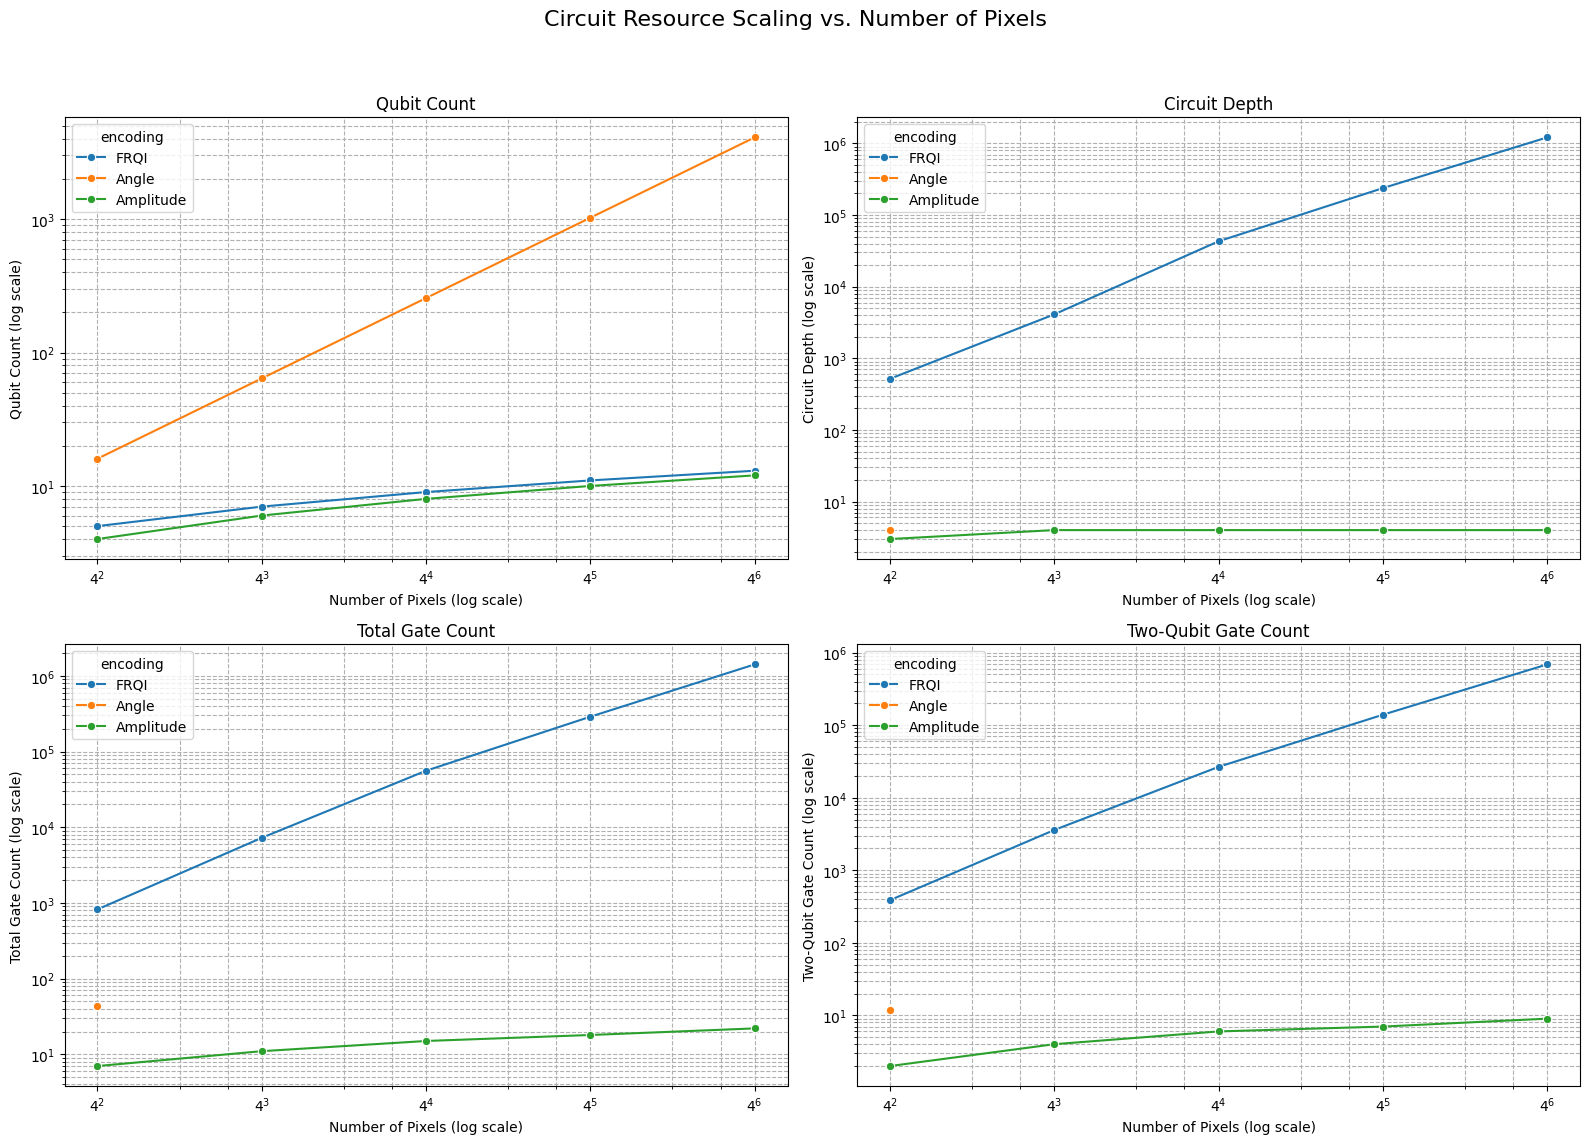

In [88]:
import numpy as np
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import RYGate
from qiskit_aer import AerSimulator
from qiskit.transpiler.exceptions import CircuitTooWideForTarget # Import the specific error

# ===================================================================
# Part 1: Helper Functions
# ===================================================================

def create_encoder(features, encoding_method='FRQI'):
    # (This function remains the same as the previous version)
    num_pixels = len(features)
    if encoding_method == 'FRQI':
        num_pos_qubits = int(np.ceil(np.log2(num_pixels)))
        num_qubits = num_pos_qubits + 1
        qc = QuantumCircuit(num_qubits)
        color_qubit, pos_qubits = 0, list(range(1, num_qubits))
        angles = (features / 255.0) * (np.pi / 2)
        qc.h(pos_qubits)
        for i, angle in enumerate(angles):
            if np.isclose(angle, 0): continue
            control_state = format(i, f'0{num_pos_qubits}b')
            for j, bit in enumerate(reversed(control_state)):
                if bit == '0': qc.x(pos_qubits[j])
            mcr_gate = RYGate(2 * angle).control(num_pos_qubits)
            qc.append(mcr_gate, pos_qubits + [color_qubit])
            for j, bit in enumerate(reversed(control_state)):
                if bit == '0': qc.x(pos_qubits[j])
        return qc
    elif encoding_method == 'Angle':
        qc = QuantumCircuit(num_pixels)
        angles = (features / 255.0) * np.pi
        for i, angle in enumerate(angles):
            qc.ry(angle, i)
        return qc
    elif encoding_method == 'Amplitude':
        num_qubits = int(np.ceil(np.log2(num_pixels)))
        qc = QuantumCircuit(num_qubits)
        norm = np.linalg.norm(features)
        if np.isclose(norm, 0): features[0] = 1e-9
        amplitudes = features / np.linalg.norm(features)
        qc.initialize(amplitudes, range(num_qubits))
        return qc
    else:
        raise ValueError("Invalid encoding method")

def add_qcnn_layers(qc):
    # (This function remains the same)
    num_qubits = qc.num_qubits
    if num_qubits < 2: return
    for i in range(0, num_qubits - 1, 2):
        qc.cx(i, i + 1)
        qc.rz(np.random.rand(), i)
        qc.ry(np.random.rand(), i + 1)
    if num_qubits > 4:
        for i in range(num_qubits // 2, num_qubits - 1, 2):
            qc.cz(i, i + 1)

def build_and_analyze_circuit(image_size, encoding_method):
    """Builds the pipeline and gracefully handles circuits that are too large."""
    print(f"Analyzing {encoding_method} for {image_size}x{image_size} image...")
    num_pixels = image_size * image_size
    features = np.random.randint(1, 256, num_pixels)
    
    qc = create_encoder(features, encoding_method)
    add_qcnn_layers(qc)
    
    # --- THE FIX IS HERE: Use a try...except block ---
    try:
        backend = AerSimulator()
        transpiled_qc = transpile(qc, backend)
        
        depth = transpiled_qc.depth()
        total_gates = len(transpiled_qc.data)
        two_qubit_gates = transpiled_qc.count_ops().get('cx', 0) + \
                          transpiled_qc.count_ops().get('cz', 0)
        
        print(f"  -> Qubits: {qc.num_qubits}, Depth: {depth}, Gates: {total_gates}, CNOTs: {two_qubit_gates}")
        
        return {
            'encoding': encoding_method, 'size': image_size, 'pixels': num_pixels,
            'qubits': qc.num_qubits, 'depth': depth, 'total_gates': total_gates,
            'cnot_gates': two_qubit_gates
        }
    
    except CircuitTooWideForTarget:
        print(f"  -> SKIPPING (Circuit too wide): {qc.num_qubits} qubits exceeds simulator limit.")
        # Return NaN for metrics that couldn't be computed
        return {
            'encoding': encoding_method, 'size': image_size, 'pixels': num_pixels,
            'qubits': qc.num_qubits, 'depth': np.nan, 'total_gates': np.nan,
            'cnot_gates': np.nan
        }
    # ----------------------------------------------------

# ===================================================================
# Part 2: Main Loop and Visualization (Unchanged)
# ===================================================================

IMAGE_SIZES = [4, 8, 16, 32, 64]
results = []

for size in IMAGE_SIZES:
    for method in ['FRQI', 'Angle', 'Amplitude']:
        metrics = build_and_analyze_circuit(size, method)
        if metrics: results.append(metrics)
    
results_df = pd.DataFrame(results)
print("\n--- Results Summary ---")
print(results_df.to_string())

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Circuit Resource Scaling vs. Number of Pixels', fontsize=16)
metrics_to_plot = [('qubits', 'Qubit Count'), ('depth', 'Circuit Depth'), 
                   ('total_gates', 'Total Gate Count'), ('cnot_gates', 'Two-Qubit Gate Count')]

for i, (metric, title) in enumerate(metrics_to_plot):
    ax = axes[i//2, i%2]
    sns.lineplot(data=results_df, x='pixels', y=metric, hue='encoding', marker='o', ax=ax)
    ax.set_xscale('log', base=4)
    ax.set_yscale('log')
    ax.set_title(title)
    ax.set_xlabel('Number of Pixels (log scale)')
    ax.set_ylabel(f'{title} (log scale)')
    ax.grid(True, which="both", ls="--")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 6 
a) T=51 there is 51 unrelated parameter and this T is constant as the number of qubit increase
b) M scale like O(nb_qbit*depth)

Loading BreastMNIST data...
Training data shape: (400, 64)
Test data shape: (100, 64)
Unique labels: [0 1]


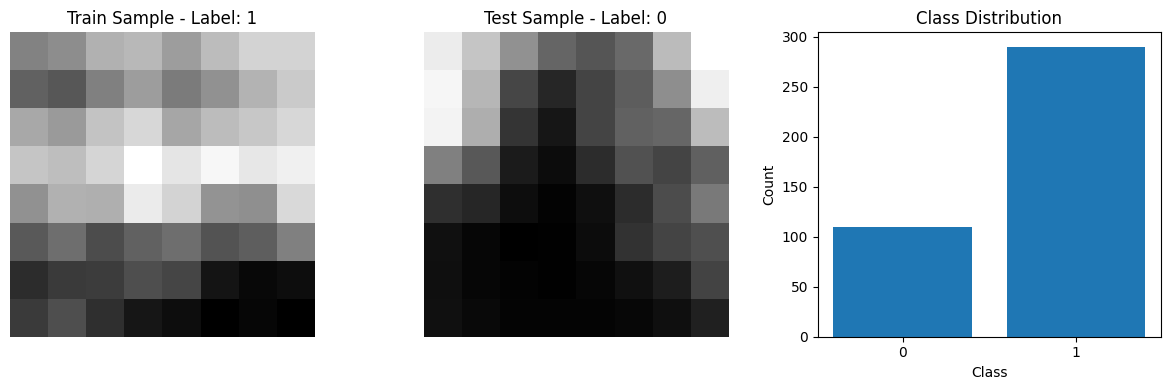


Starting QCNN training with amplitude encoding...
Quantum parameters: 36
Feature dimension: 64 (2^6)
Epoch: 1, Batch: 0, Loss: 1.0656
Epoch: 1, Batch: 10, Loss: 0.9778
Epoch: 1, Batch: 20, Loss: 0.8412
Epoch 1/10 | Time: 180.67s
Train Loss: 1.0699 | Train Acc: 27.50%
Val Loss: 0.9915 | Val Acc: 24.00%
--------------------------------------------------
Epoch: 2, Batch: 0, Loss: 1.0263
Epoch: 2, Batch: 10, Loss: 0.9380
Epoch: 2, Batch: 20, Loss: 0.6915
Epoch 2/10 | Time: 180.13s
Train Loss: 0.8459 | Train Acc: 27.50%
Val Loss: 0.7649 | Val Acc: 24.00%
--------------------------------------------------
Epoch: 3, Batch: 0, Loss: 0.7695


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

# Qiskit imports
from qiskit import QuantumCircuit
from qiskit.circuit.library import BlueprintCircuit
from qiskit.quantum_info import Statevector, Operator
from qiskit.circuit import ParameterVector

def load_breastmnist_data(num_train=400, num_test=100):
    """Load and preprocess BreastMNIST data"""
    from medmnist import BreastMNIST
    from torchvision import transforms
    
    # Data transformation
    data_transform = transforms.Compose([
        transforms.Resize((8, 8)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[.5], std=[.5])
    ])
    
    # Load datasets
    train_dataset = BreastMNIST(split="train", transform=data_transform, download=True)
    test_dataset = BreastMNIST(split="test", transform=data_transform, download=True)
    
    # Extract data
    x_train, y_train = [], []
    for i in range(min(num_train, len(train_dataset))):
        img, label = train_dataset[i]
        x_train.append(img.numpy())
        y_train.append(label)
    
    x_test, y_test = [], []
    for i in range(min(num_test, len(test_dataset))):
        img, label = test_dataset[i]
        x_test.append(img.numpy())
        y_test.append(label)
    
    # Convert to numpy arrays and reshape
    x_train = np.array(x_train).reshape(num_train, -1)
    y_train = np.array(y_train).flatten()
    x_test = np.array(x_test).reshape(num_test, -1)
    y_test = np.array(y_test).flatten()
    
    return x_train, y_train, x_test, y_test

def amplitude_embedding_block(features, num_qubits, pad_with=0.0, label="AmpEmbed"):
    """
    Creates a normalized amplitude embedding circuit block.
    Features are normalized to ensure statevector validity.
    """
    # Ensure features is a 1D array
    features = np.asarray(features, dtype=float).flatten()
    
    # Pad or truncate features to fit 2^num_qubits
    target_dim = 2 ** num_qubits
    if len(features) < target_dim:
        # Pad with the specified value
        features = np.pad(features, (0, target_dim - len(features)), 
                         constant_values=pad_with)
    else:
        # Truncate to target dimension
        features = features[:target_dim]
    
    # Normalize the feature vector with tolerance check
    norm = np.linalg.norm(features)
    if np.isclose(norm, 0, atol=1e-10):
        # Fallback to |0...0⟩ state if norm is zero
        features = np.zeros(target_dim)
        features[0] = 1.0
    else:
        # Normalize and ensure exact norm of 1.0 for Qiskit
        features = features / norm
        # Force to exactly 1.0 to avoid floating point errors
        features = features / np.linalg.norm(features)
    
    # Create a quantum circuit and initialize with normalized features
    qc = QuantumCircuit(num_qubits, name=label)
    qc.initialize(features, range(num_qubits))
    
    return qc.to_instruction()

def create_qcnn_circuit(features, params, num_qubits=6):
    """
    Create a QCNN circuit with amplitude encoding
    """
    qc = QuantumCircuit(num_qubits)
    
    # Apply amplitude embedding
    embed_gate = amplitude_embedding_block(features, num_qubits)
    qc.append(embed_gate, range(num_qubits))
    
    # Apply parameterized quantum layers (simplified QCNN)
    param_idx = 0
    num_layers = len(params) // (2 * num_qubits)
    
    for layer in range(num_layers):
        # Apply RY rotations
        for i in range(num_qubits):
            if param_idx < len(params):
                qc.ry(params[param_idx], i)
                param_idx += 1
        
        # Apply RZ rotations  
        for i in range(num_qubits):
            if param_idx < len(params):
                qc.rz(params[param_idx], i)
                param_idx += 1
        
        # Apply entangling gates (simplified convolution)
        for i in range(0, num_qubits-1, 2):
            qc.cx(i, i+1)
        
        qc.barrier()
    
    return qc

class QuantumCircuitFunction(torch.autograd.Function):
    @staticmethod
    def _run_circuit(features, params):
        """Run quantum circuit and return expectation values"""
        expectation_values = []
        num_qubits = 6  # Fixed for 64 features (2^6 = 64)
        
        # Define observable (Z on first qubit)
        observable = Operator(np.kron(np.diag([1, -1]), np.identity(2**(num_qubits-1))))
        
        for feature_vec in features:
            try:
                # Convert to numpy and ensure proper shape
                feature_np = feature_vec.detach().numpy() if isinstance(feature_vec, torch.Tensor) else feature_vec
                feature_np = feature_np.astype(np.float64)
                
                # Create and run circuit
                qc = create_qcnn_circuit(feature_np, params.detach().numpy(), num_qubits)
                statevector = Statevector(qc)
                exp_val = statevector.expectation_value(observable).real
                expectation_values.append(exp_val)
                
            except Exception as e:
                print(f"Circuit execution error: {e}")
                # Fallback: return random value (will be improved during training)
                expectation_values.append(0.0)
                
        return torch.tensor(expectation_values, dtype=torch.float32)

    @staticmethod
    def forward(ctx, features, params):
        ctx.save_for_backward(features, params)
        return QuantumCircuitFunction._run_circuit(features, params)

    @staticmethod
    def backward(ctx, grad_output):
        features, params = ctx.saved_tensors
        gradients = torch.zeros_like(params)
        shift = np.pi / 2
        
        # Parameter shift rule for gradient computation
        for i in range(len(params)):
            params_up = params.clone()
            params_down = params.clone()
            params_up[i] += shift
            params_down[i] -= shift
            
            exp_val_up = QuantumCircuitFunction._run_circuit(features, params_up)
            exp_val_down = QuantumCircuitFunction._run_circuit(features, params_down)
            
            gradient = 0.5 * (exp_val_up - exp_val_down)
            gradients[i] = (grad_output * gradient).sum()
            
        return None, gradients

class QuantumLayer(nn.Module):
    def __init__(self, num_params):
        super(QuantumLayer, self).__init__()
        self.params = nn.Parameter(torch.rand(num_params) * 2 * np.pi)

    def forward(self, features):
        return QuantumCircuitFunction.apply(features, self.params)

class HybridQCNN(nn.Module):
    def __init__(self, num_quantum_params, num_classes):
        super(HybridQCNN, self).__init__()
        # Classical preprocessing layer to ensure correct feature dimension
        self.pre_net = nn.Linear(64, 64)  # 8x8 = 64 features
        self.quantum_layer = QuantumLayer(num_quantum_params)
        self.classical_layer = nn.Linear(1, num_classes)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.pre_net(x)  # Ensure features are in right dimension
        x = self.quantum_layer(x)
        x = x.unsqueeze(1)  # Add dimension for linear layer
        x = self.classical_layer(x)
        return x

# Training configuration
NUM_QUBITS = 6
NUM_PIXELS = 2**NUM_QUBITS  # 64
NUM_CLASSES = 2
BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 0.1

# Calculate number of quantum parameters (2 params per qubit per layer × 3 layers)
NUM_QUANTUM_PARAMS = 3 * 2 * NUM_QUBITS  # 36 parameters

def main():
    print("Loading BreastMNIST data...")
    x_train, y_train, x_test, y_test = load_breastmnist_data(num_train=400, num_test=100)
    
    print(f"Training data shape: {x_train.shape}")
    print(f"Test data shape: {x_test.shape}")
    print(f"Unique labels: {np.unique(y_train)}")
    
    # Show sample image
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.imshow(x_train[0].reshape(8, 8), cmap='gray')
    plt.title(f"Train Sample - Label: {y_train[0]}")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(x_test[0].reshape(8, 8), cmap='gray')
    plt.title(f"Test Sample - Label: {y_test[0]}")
    plt.axis('off')
    
    # Show data distribution
    plt.subplot(1, 3, 3)
    unique, counts = np.unique(y_train, return_counts=True)
    plt.bar(unique, counts)
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(unique)
    
    plt.tight_layout()
    plt.show()
    
    # Convert to PyTorch tensors
    x_train_tensor = torch.FloatTensor(x_train)
    y_train_tensor = torch.LongTensor(y_train)
    x_test_tensor = torch.FloatTensor(x_test)
    y_test_tensor = torch.LongTensor(y_test)
    
    # Create data loaders
    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
    
    # Initialize model
    model = HybridQCNN(num_quantum_params=NUM_QUANTUM_PARAMS, num_classes=NUM_CLASSES)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()
    
    # Training history
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    print("\nStarting QCNN training with amplitude encoding...")
    print(f"Quantum parameters: {NUM_QUANTUM_PARAMS}")
    print(f"Feature dimension: {NUM_PIXELS} (2^{NUM_QUBITS})")
    
    for epoch in range(EPOCHS):
        start_time = time.time()
        
        # Training phase
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            if batch_idx % 10 == 0:
                print(f'Epoch: {epoch+1}, Batch: {batch_idx}, Loss: {loss.item():.4f}')
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        
        # Validation phase
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(test_loader)
        val_acc = 100 * correct / total
        
        # Store history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        epoch_time = time.time() - start_time
        print(f'Epoch {epoch+1}/{EPOCHS} | Time: {epoch_time:.2f}s')
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
        print('-' * 50)
    
    # Plot results
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Training Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    print("\nTraining completed!")
    print(f"Final Training Accuracy: {history['train_acc'][-1]:.2f}%")
    print(f"Final Validation Accuracy: {history['val_acc'][-1]:.2f}%")
    
    # Test the model
    model.eval()
    with torch.no_grad():
        test_outputs = model(x_test_tensor)
        _, test_predicted = torch.max(test_outputs.data, 1)
        test_accuracy = 100 * (test_predicted == y_test_tensor).sum().item() / len(y_test_tensor)
        print(f"Test Accuracy: {test_accuracy:.2f}%")

if __name__ == "__main__":
    main()

## QCNN Scaling Plot: What You’ll Need to Replicate

Next step is to compare **different data encoding strategies** (Amplitude, Angle, QPIE, etc.) and analyze how they affect the **scaling behavior** of a Quantum Convolutional Neural Network (QCNN) circuit.

#### This includes plotting how metrics like:
- **Total Gate Count**
- **CX (CNOT) Gate Count**
- **Circuit Depth**

change as you increase:
1. The **picture resolution** (e.g. 8x8 → 16x16)
2. The **encoding method** (Amplitude vs Angle vs QPIE, etc.)

#### What to Plot & Report

Use your imagination and scientific judgment to create informative visualizations. Your plots should:

Show how the circuit scales with input size and encoding method

Highlight any bottlenecks in circuit depth or entanglement gates

Compare different encodings side by side where possible

Justify your findings using relevant literature

### We are happy to help!